# Assignment 3

Deadline: 09.04.2025 12:00 CET

<Add your name, student-id and emal address>

In [98]:
# Standard library imports
import os
import sys
import types

# Third party imports
import numpy as np
import pandas as pd

# Add the project root directory to Python path
project_root = os.path.dirname(
    os.path.dirname(os.getcwd())
)  # <Change this path if needed>
src_path = os.path.join(project_root, "qpmwp-course\\src")
sys.path.append(project_root)
sys.path.append(src_path)

# Local modules imports
from src.helper_functions import load_data_msci
from src.estimation.covariance import Covariance
from src.estimation.expected_return import ExpectedReturn
from src.optimization.optimization import MeanVariance
from src.backtesting.backtest_item_builder_classes import (
    SelectionItemBuilder,
    OptimizationItemBuilder,
)
from src.backtesting.backtest_item_builder_functions import (
    bibfn_selection_data_random,
    bibfn_return_series,
    bibfn_budget_constraint,
    bibfn_box_constraints,
)
from src.backtesting.portfolio import floating_weights
from src.backtesting.backtest_service import BacktestService
from src.backtesting.backtest import Backtest

### Data load

In [99]:
N = 24
data = load_data_msci(path="../data/", n=N)  # <Change the path if needed>

### Prepare backtest service

In [100]:
# Define rebalancing dates
n_days = 21 * 3
start_date = "2010-01-01"
dates = data["return_series"].index
rebdates = dates[dates > start_date][::n_days].strftime("%Y-%m-%d").tolist()

# Define the selection item builders.
selection_item_builders = {
    "data": SelectionItemBuilder(
        bibfn=bibfn_selection_data_random,
        k=10,
        seed=42,
    ),
}

# Define the optimization item builders.
optimization_item_builders = {
    "return_series": OptimizationItemBuilder(
        bibfn=bibfn_return_series,
        width=365 * 3,
    ),
    "budget_constraint": OptimizationItemBuilder(
        bibfn=bibfn_budget_constraint,
        budget=1,
    ),
    "box_constraints": OptimizationItemBuilder(
        bibfn=bibfn_box_constraints,
        upper=0.5,
    ),
}

# Initialize the backtest service
bs = BacktestService(
    data=data,
    selection_item_builders=selection_item_builders,
    optimization_item_builders=optimization_item_builders,
    optimization=MeanVariance(
        covariance=Covariance(method="pearson"),
        expected_return=ExpectedReturn(method="geometric"),
        risk_aversion=1,
        solver_name="cvxopt",
    ),
    rebdates=rebdates,
)

### Run the backtest

In [101]:
# Instantiate the backtest object and run the backtest
bt_mv = Backtest()

# Run the backtest
bt_mv.run(bs=bs)

Rebalancing date: 2010-01-04
Rebalancing date: 2010-04-01
Rebalancing date: 2010-06-29
Rebalancing date: 2010-09-24
Rebalancing date: 2010-12-22
Rebalancing date: 2011-03-21
Rebalancing date: 2011-06-16
Rebalancing date: 2011-09-13
Rebalancing date: 2011-12-09
Rebalancing date: 2012-03-07
Rebalancing date: 2012-06-04
Rebalancing date: 2012-08-30
Rebalancing date: 2012-11-27
Rebalancing date: 2013-02-22
Rebalancing date: 2013-05-22
Rebalancing date: 2013-08-19
Rebalancing date: 2013-11-14
Rebalancing date: 2014-02-11
Rebalancing date: 2014-05-09
Rebalancing date: 2014-08-06
Rebalancing date: 2014-11-03
Rebalancing date: 2015-01-29
Rebalancing date: 2015-04-28
Rebalancing date: 2015-07-24
Rebalancing date: 2015-10-21
Rebalancing date: 2016-01-18
Rebalancing date: 2016-04-14
Rebalancing date: 2016-07-12
Rebalancing date: 2016-10-07
Rebalancing date: 2017-01-04
Rebalancing date: 2017-04-03
Rebalancing date: 2017-06-29
Rebalancing date: 2017-09-26
Rebalancing date: 2017-12-22
Rebalancing da

## 1. Turnover

**(6 points)**

Complete the function `turnover`.

In [102]:
def turnover(self, return_series: pd.DataFrame, rescale: bool = True):
    dates = self.get_rebalancing_dates()
    to = {}
    to[dates[0]] = float(1)
    for rebalancing_date in dates[1:]:
        previous_portfolio = self.get_previous_portfolio(rebalancing_date)
        current_portfolio = self.get_portfolio(rebalancing_date)

        if (
            current_portfolio.rebalancing_date is None
            or previous_portfolio.rebalancing_date is None
        ):
            raise ValueError("Portfolios must have a rebalancing date")

        if current_portfolio.rebalancing_date < previous_portfolio.rebalancing_date:
            raise ValueError(
                "The previous portfolio must be older than the current portfolio"
            )

        previous_weights = previous_portfolio.get_weights_series()
        current_weights = current_portfolio.get_weights_series()

        # Get the union of the ids of the weights in both portfolios (previous and current)
        previous_portfolio_ids = previous_weights.index
        current_portfolio_ids = current_weights.index
        union_ids = previous_portfolio_ids.union(current_portfolio_ids)

        # Extend the weights of the previous portfolio to the union of ids in both portfolios by adding zeros
        previous_weights_extended = previous_weights.reindex(union_ids).fillna(0)
        current_weights_extended = current_weights.reindex(union_ids).fillna(0)

        # Float the weights of the previous portfolio according to the price drifts in the market
        # until the current rebalancing date
        # Hint: use function floating_weights from module portfolio.py
        previous_weights_extended = floating_weights(
            X=return_series,
            w=previous_weights_extended,
            start_date=previous_portfolio.rebalancing_date,
            end_date=rebalancing_date,
            rescale=rescale,
        ).loc[current_portfolio.rebalancing_date]

        # Extract the weights of the current portfolio
        # Calculate the turnover
        to[rebalancing_date] = (
            np.abs(current_weights_extended - previous_weights_extended).sum().sum()
        )

    return pd.Series(to)

2: Simulation

(6 points)

Complete the function `simulate`.

In [103]:
def simulate(
    self,
    return_series: pd.DataFrame,
    fc: float = 0,
    vc: float = 0,
    n_days_per_year: int = 252,
) -> pd.Series:
    rebdates = self.get_rebalancing_dates()
    ret_list = []
    for rebdate in rebdates:
        next_rebdate = (
            rebdates[rebdates.index(rebdate) + 1]
            if rebdate < rebdates[-1]
            else return_series.index[-1]
        )

        portfolio = self.get_portfolio(rebdate)
        w_float = portfolio.float_weights(
            return_series=return_series,
            end_date=next_rebdate,
            rescale=False,  # Notice that rescale is hardcoded to False.
        )
        level = w_float.sum(axis=1)
        ret_tmp = level.pct_change(1)
        ret_list.append(ret_tmp)

    portf_ret = pd.concat(ret_list).dropna()

    if vc != 0:
        # Calculate turnover
        to = self.turnover(return_series=return_series, rescale=False)
        # Calculate variable cost (vc) as a fraction of turnover and
        # subtract the variable cost from the returns at each rebalancing date
        vc_cost = vc * to

        # As variable costs are paid only at the date of rebalancing,
        # we need to just pick the points of rebalancing and subtract there
        vc_cost.index = pd.to_datetime(vc_cost.index)
        vc_cost = vc_cost.reindex(portf_ret.index).fillna(0)
        portf_ret = portf_ret - vc_cost

    if fc != 0:
        # Calculate number of days between returns
        # Calculate daily fixed cost based on the annual fixed cost (fc),
        # the number of days between two rebalancings and the number of days per year.
        # Subtract the daily fixed cost from the daily returns
        daily_fc = fc / n_days_per_year
        days_diff = portf_ret.index.diff().days.to_numpy()
        days_diff[0] = 1
        fc_cost = daily_fc * days_diff

        portf_ret = portf_ret - fc_cost

    return portf_ret

Overwrite the turnover and the simulation methods of the current strategy object.

In [104]:
# Overwrite the turnover method of the strategy object
bt_mv.strategy.turnover = types.MethodType(turnover, bt_mv.strategy)

# Overwrite the simulate method of the strategy object
bt_mv.strategy.simulate = types.MethodType(simulate, bt_mv.strategy)

Calculate and plot the turnover.

<Axes: title={'center': 'Turnover'}>

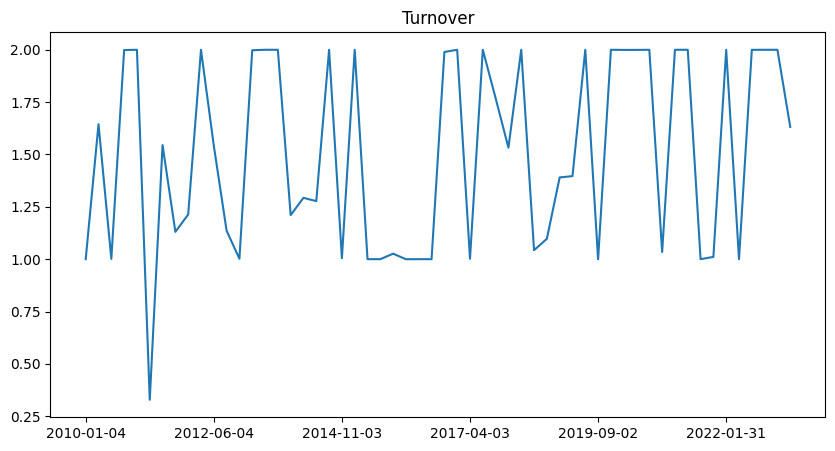

In [105]:
bt_mv.strategy.turnover(
    return_series=data["return_series"],
    rescale=True,
).plot(title="Turnover", figsize=(10, 5))

Simulate with different cost assumptions.

In [106]:
return_series = bs.data["return_series"]

sim_mv_gross = bt_mv.strategy.simulate(return_series=return_series, fc=0, vc=0)
sim_mv_net_of_fc = bt_mv.strategy.simulate(return_series=return_series, fc=0.01, vc=0)
sim_mv_net_of_vc = bt_mv.strategy.simulate(return_series=return_series, fc=0, vc=0.002)
sim_mv_net = bt_mv.strategy.simulate(return_series=return_series, fc=0.01, vc=0.002)

Plot the cumulative returns.

<Axes: xlabel='Index'>

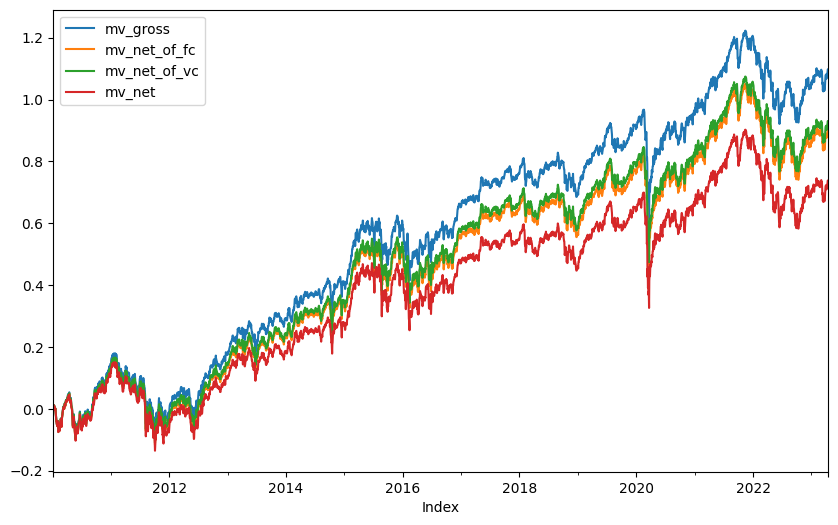

In [107]:
sim = pd.concat(
    {
        "mv_gross": sim_mv_gross,
        "mv_net_of_fc": sim_mv_net_of_fc,
        "mv_net_of_vc": sim_mv_net_of_vc,
        "mv_net": sim_mv_net,
    },
    axis=1,
).dropna()


np.log((1 + sim)).cumsum().plot(figsize=(10, 6))

3: Descriptive Statistics

(3 points)

Generate a table with descriptive statistics of the simulations. Include the following statistics:
- cumulative return (i.e., the return over the entire simulation period)
- annualized average returns
- annualized volatility
- sharpe ratio
- maximum drawdown

In [108]:
strategies = pd.DataFrame(index=sim_mv_gross.index)
strategies["mv_gross"] = sim_mv_gross
strategies["mv_net_of_fc"] = sim_mv_net_of_fc
strategies["mv_net_of_vc"] = sim_mv_net_of_vc
strategies["mv_net"] = sim_mv_net
strategies

,mv_gross,mv_net_of_fc,mv_net_of_vc,mv_net
Index,,,,
2010-01-05,0.005455,0.005415,0.005455,0.005415
2010-01-06,-0.000439,-0.000478,-0.000439,-0.000478
2010-01-07,-0.003031,-0.003071,-0.003031,-0.003071
2010-01-08,0.003712,0.003672,0.003712,0.003672
2010-01-11,0.005566,0.005447,0.005566,0.005447
...,...,...,...,...
2023-04-12,0.003083,0.003043,0.003083,0.003043
2023-04-13,0.004226,0.004186,0.004226,0.004186
2023-04-14,0.007601,0.007561,0.007601,0.007561


In [109]:
class Assessor:
    N_DAYS_PER_YEAR: int = 252

    def __init__(self, rf_rate: pd.Series) -> None:
        self.rf_rate = rf_rate

    @staticmethod
    def _get_max_drawdown(total_returns: pd.DataFrame) -> np.ndarray:
        total_nav = total_returns.add(1).cumprod(axis=0)
        prev_peak = total_nav.cummax(axis=0)

        return ((total_nav - prev_peak) / prev_peak).min(axis=0)

    def _run(self, strategies_total_r: pd.DataFrame) -> pd.DataFrame:
        factor_annual = (
            self.N_DAYS_PER_YEAR // strategies_total_r.index.diff().min().days
        )
        n_periods = strategies_total_r.shape[0] / factor_annual

        final_nav = strategies_total_r.add(1).prod(axis=0)
        final_rf = self.rf_rate.add(1).prod(axis=0)

        strat_mean = final_nav ** (1 / n_periods) - 1
        rf_mean = final_rf ** (1 / n_periods) - 1

        strat_std = strategies_total_r.std(axis=0) * np.sqrt(factor_annual)

        sharpe_ratio = (strat_mean - rf_mean) / strat_std

        strategy_max_dd = self._get_max_drawdown(strategies_total_r)

        metrics = pd.DataFrame(index=strategies_total_r.columns)
        metrics.loc[:, "Cumulative Return"] = final_nav.cumprod() - 1
        metrics.loc[:, "Annualized Average Returns"] = strat_mean * 100
        metrics.loc[:, "Annualized Volatility"] = strat_std * 100
        metrics.loc[:, "Sharpe Ratio"] = sharpe_ratio
        metrics.loc[:, "Maximum Drawdown"] = strategy_max_dd * 100

        return metrics

    def __call__(self, strategies_total_r: pd.DataFrame) -> pd.DataFrame:
        return self._run(strategies_total_r)


assessor = Assessor(
    rf_rate=pd.Series(index=data["return_series"].index, data=0.03 / 365)
)
strat_metrics = assessor(strategies)
strat_metrics

,Cumulative Return,Annualized Average Returns,Annualized Volatility,Sharpe Ratio,Maximum Drawdown
mv_gross,1.997802,8.309505,14.743567,0.301794,-30.749402
mv_net_of_fc,6.413054,6.804043,14.744711,0.199669,-30.842204
mv_net_of_vc,17.760140,6.983797,14.755620,0.211704,-31.031576
mv_net,38.161782,5.496693,14.756737,0.110913,-31.124011
